# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
assert df.shape == (1460, 80)

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

Kurtosis: 6.509812011089439


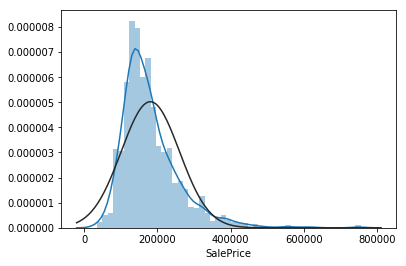

In [5]:
import scipy as sp

sns.distplot(df.SalePrice, fit=sp.stats.norm)

print('Kurtosis:', sp.stats.kurtosis(df.SalePrice))

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.164745194154, 180921.19589041095, 0.93196656415129886))

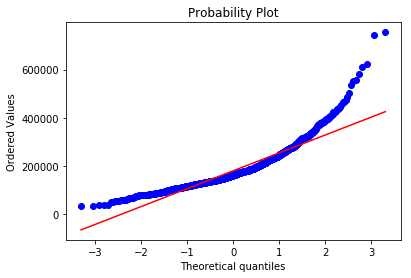

In [6]:
sp.stats.probplot(df.SalePrice, plot=plt)

Распределение нашего целевого признака отклоняется от ближайшего нормально распределённого теоретического признака.
Иными словами, нельзя сказать, что признак SalePrice в данной выборке нормально распределён.

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

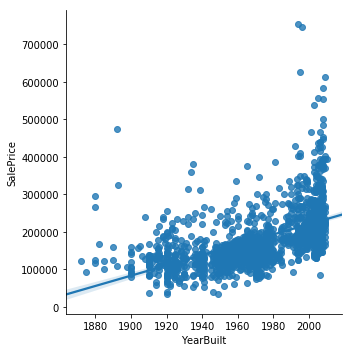

In [7]:
sns.lmplot('YearBuilt', 'SalePrice', data=df)

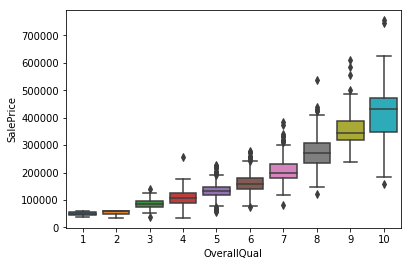

In [8]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df)

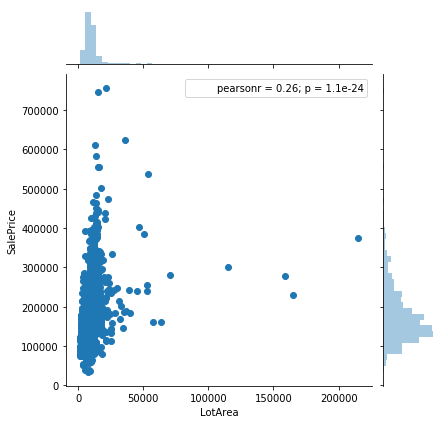

In [9]:
sns.jointplot(x='LotArea', y='SalePrice', data=df)

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

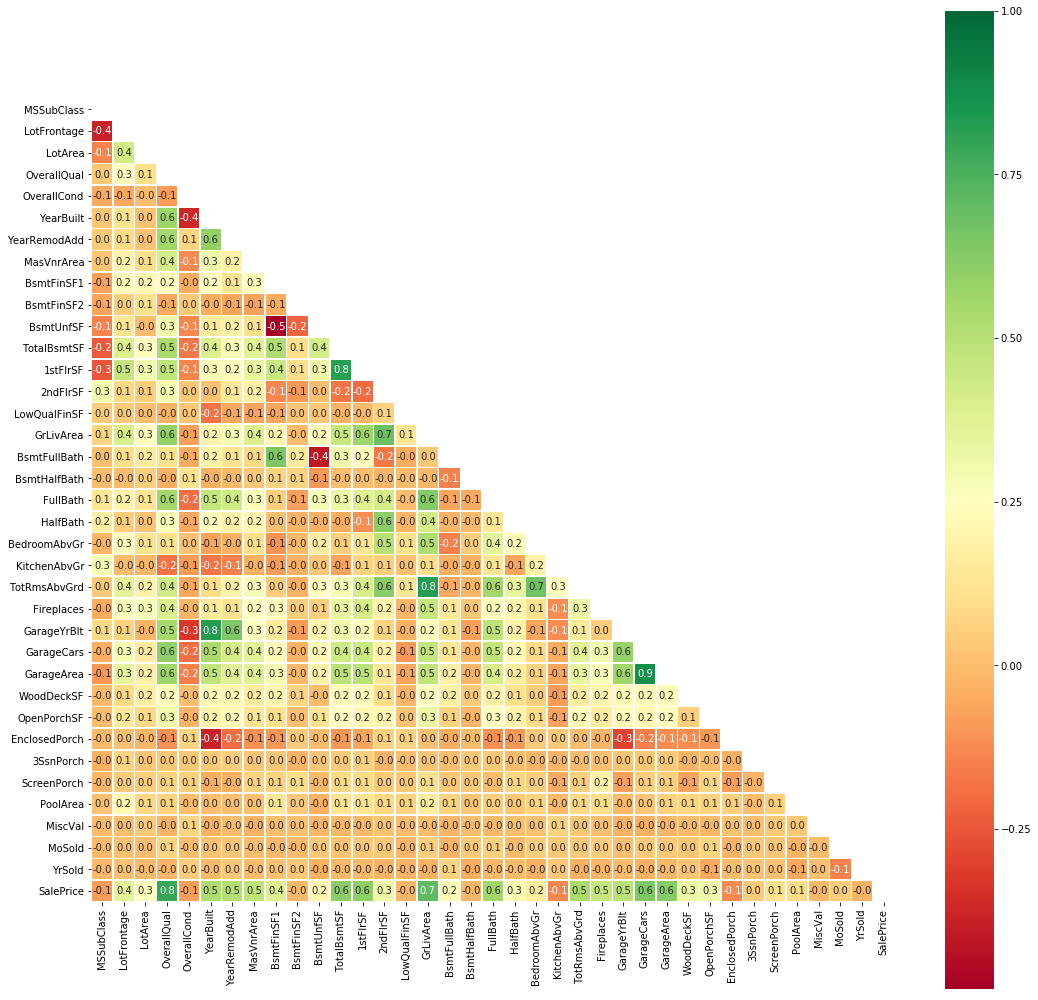

In [10]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(18, 18))
sns.heatmap(corr, cmap="RdYlGn", square=True, linewidths=.5, mask=mask, annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

In [11]:
high_corr_features = corr[np.abs(corr) > 0.5].SalePrice.drop('SalePrice', axis=0).dropna(axis=0).index
new_corr = corr[high_corr_features]
new_corr = new_corr[new_corr.index == 'SalePrice']

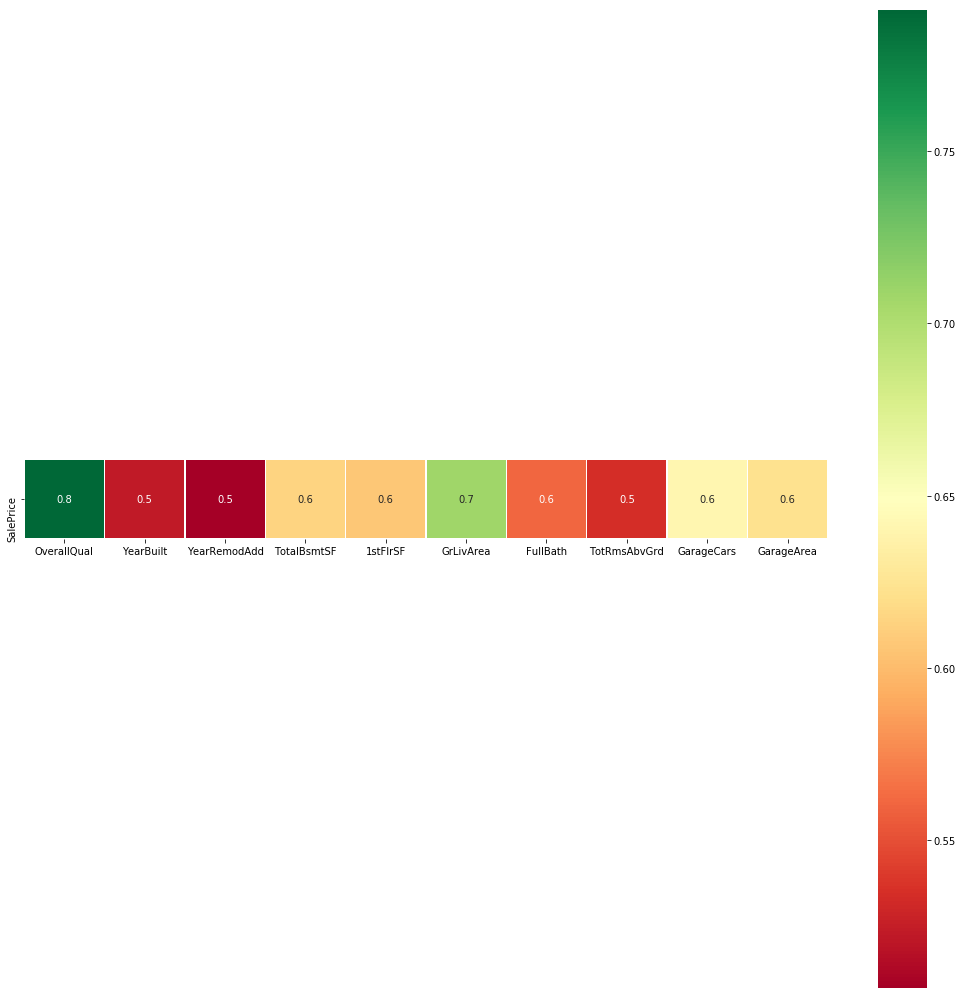

In [12]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(new_corr, cmap="RdYlGn", square=True, linewidths=.5, annot=True, fmt=".1f")

In [13]:
high_corr_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'],
      dtype='object')

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [14]:
nan_feat_quantity = len(df) - df.count()
nan_portion = nan_feat_quantity / len(df)

In [15]:
print('NaN features quantity:')
print(nan_feat_quantity)

NaN features quantity:
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCon

In [16]:
print('NaN features protion:')
print(nan_portion)

NaN features protion:
MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
Street           0.000000
Alley            0.937671
LotShape         0.000000
LandContour      0.000000
Utilities        0.000000
LotConfig        0.000000
LandSlope        0.000000
Neighborhood     0.000000
Condition1       0.000000
Condition2       0.000000
BldgType         0.000000
HouseStyle       0.000000
OverallQual      0.000000
OverallCond      0.000000
YearBuilt        0.000000
YearRemodAdd     0.000000
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
MasVnrType       0.005479
MasVnrArea       0.005479
ExterQual        0.000000
ExterCond        0.000000
Foundation       0.000000
BsmtQual         0.025342
                   ...   
BedroomAbvGr     0.000000
KitchenAbvGr     0.000000
KitchenQual      0.000000
TotRmsAbvGrd     0.000000
Functional       0.000000
Fireplaces       0.000000
FireplaceQu     

In [17]:
df = df.drop(df.columns[nan_portion[df.columns] > 0.1], axis=1)

In [18]:
objects = df.columns[df.dtypes[df.columns] == 'object']
df[objects] = df[objects].fillna('unknown')

In [19]:
floats = df.columns[df.dtypes[df.columns] == 'float64']
df[floats] = df[floats].fillna(df[floats].mean())

## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [20]:
df = pd.get_dummies(df)

In [21]:
df.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=281)

In [22]:
X, y = df.drop(labels=['SalePrice'], axis=1), df.SalePrice

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [23]:
# Ignore convergence warnings.
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
%time model.fit(X, y)

CPU times: user 192 ms, sys: 192 ms, total: 384 ms
Wall time: 156 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
for coef, col in sorted(zip(model.coef_, df.columns), key=lambda x: np.abs(x[0])):
    print("{} \t {}".format(np.round(coef, 4), col))

0.1094 	 MiscVal
0.7671 	 LotArea
3.4569 	 OpenPorchSF
4.6765 	 EnclosedPorch
13.3537 	 WoodDeckSF
18.0216 	 GarageArea
18.7496 	 MasVnrArea
-27.0804 	 GarageYrBlt
28.4685 	 ScreenPorch
-31.5034 	 MSSubClass
32.5696 	 3SsnPorch
85.1485 	 PoolArea
97.2296 	 YearRemodAdd
320.7118 	 YearBuilt
-403.931 	 YrSold
-436.5332 	 MoSold
-618.5986 	 BsmtHalfBath
761.317 	 BsmtFullBath
1097.9981 	 TotRmsAbvGrd
1128.1459 	 HalfBath
2515.1928 	 Fireplaces
-3314.0854 	 BedroomAbvGr
3585.5236 	 FullBath
4263.1894 	 GarageCars
5702.8837 	 OverallCond
6581.9275 	 OverallQual
-12637.4293 	 KitchenAbvGr
65724.8307 	 RoofMatl_Metal
68833.3786 	 RoofMatl_Tar&Grv
77365.8795 	 RoofMatl_ClyTile
82789.518 	 RoofMatl_Roll
107535.5146 	 Utilities_AllPub
129982.3924 	 RoofMatl_WdShake
138145.671 	 LandContour_Lvl
143887.8231 	 RoofMatl_Membran
172188.4479 	 RoofMatl_CompShg
-589149.951 	 RoofStyle_Shed
4355592.3333 	 BsmtFinType2_Unf
4368633.3028 	 BsmtFinType2_GLQ
4371368.2972 	 BsmtFinType2_ALQ
4374002.08 	 BsmtF

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
np.mean(cross_val_score(model, X, y, cv=kf, n_jobs=4, scoring='neg_mean_squared_error'))

-9353491167933278.0

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [27]:
from sklearn.linear_model import Lasso, Ridge

In [28]:
alphas = np.arange(0, 501, 15)
alphas[0] = 1

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha = alpha)
    ridge.fit(X, y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

Text(0.5,1,'Ridge')

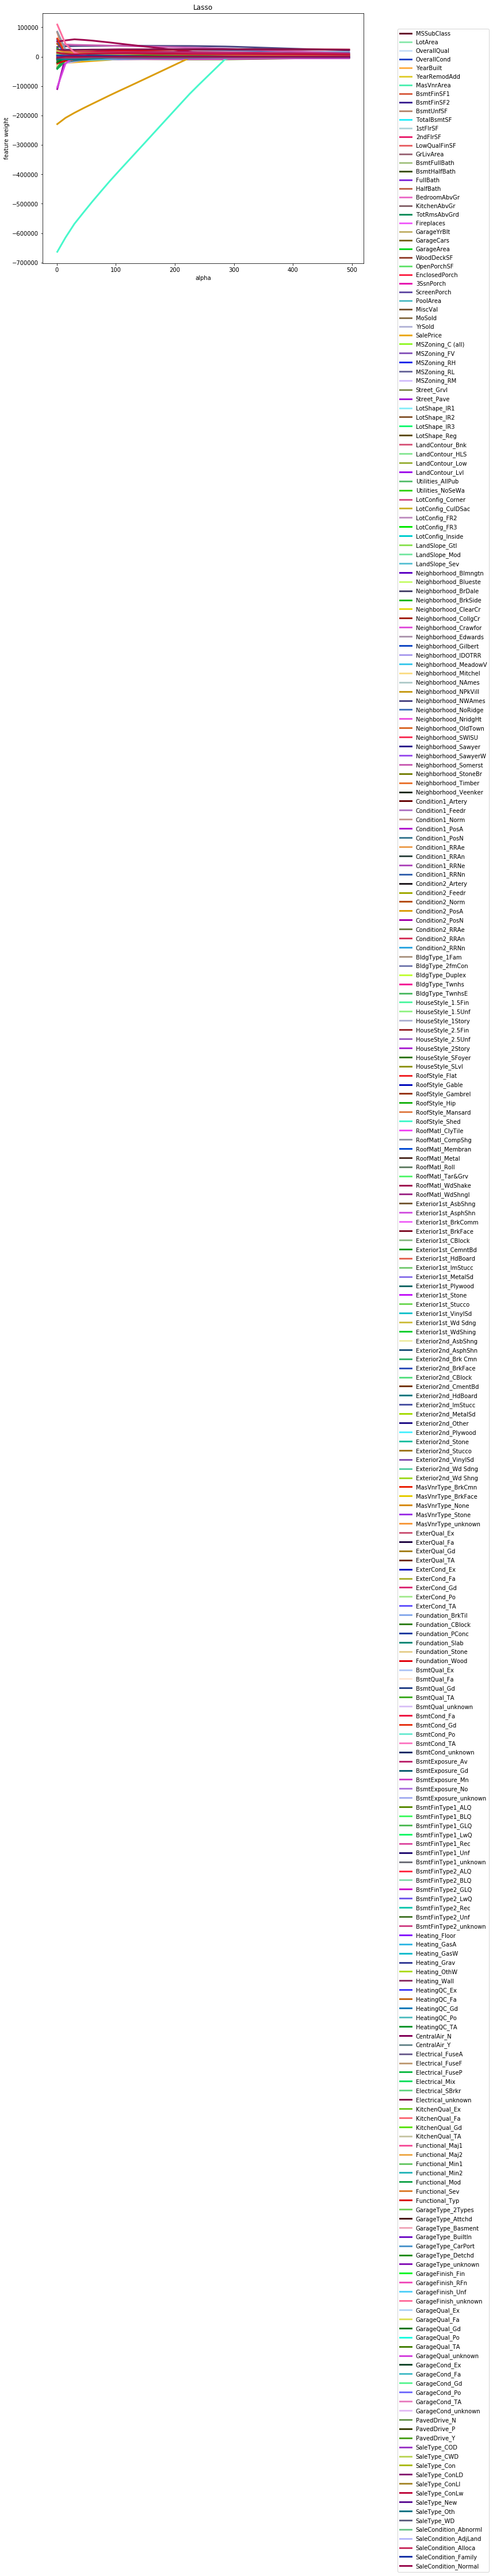

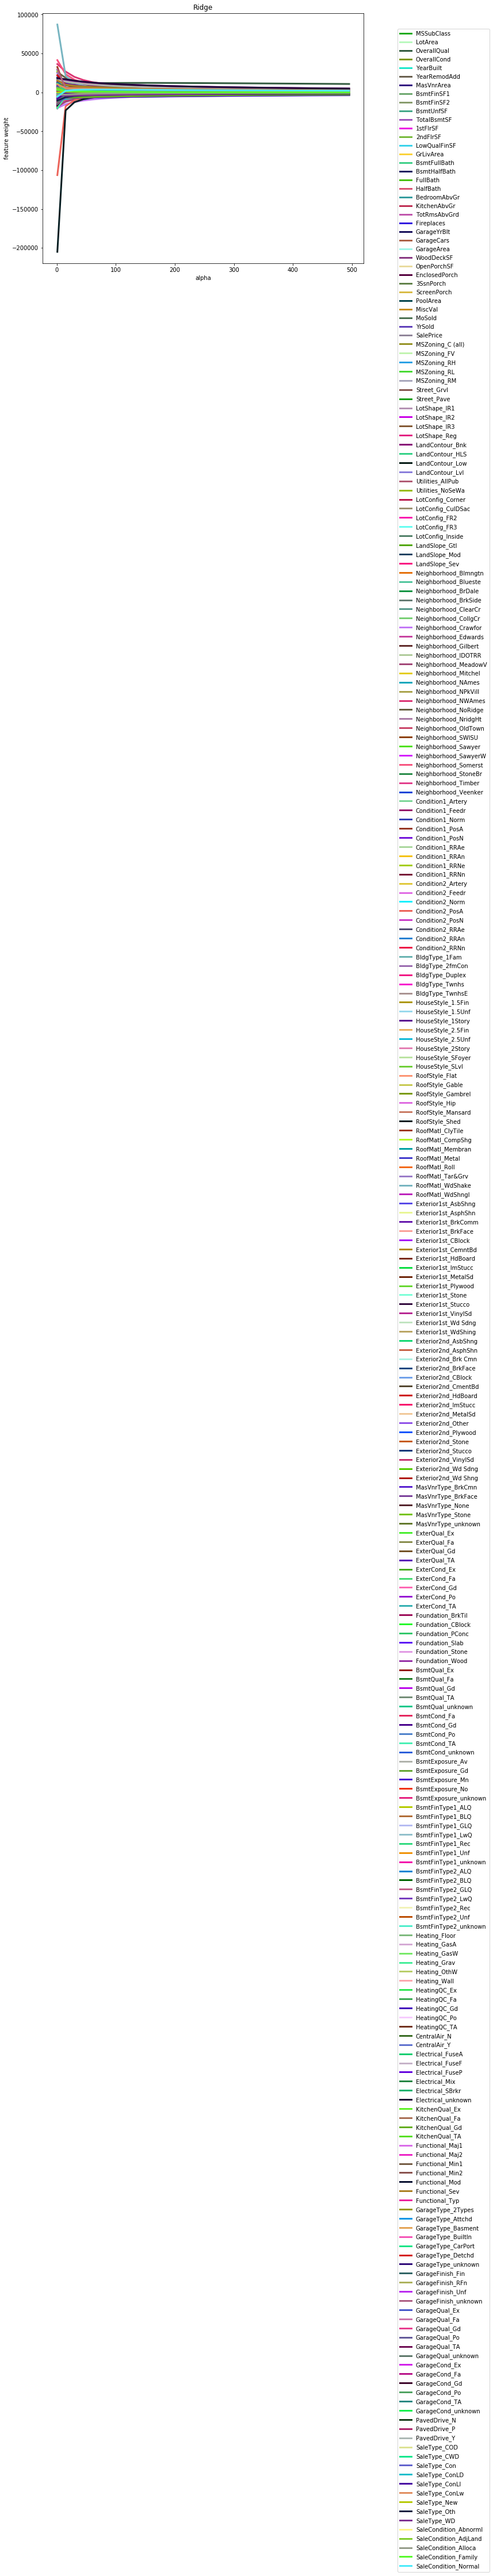

In [29]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [30]:
zero_count_lasso = []

for i in range(len(alphas)):
    line = coefs_lasso[i]
    zero_count_lasso.append(len(line[np.abs(line) < 0.0001]))

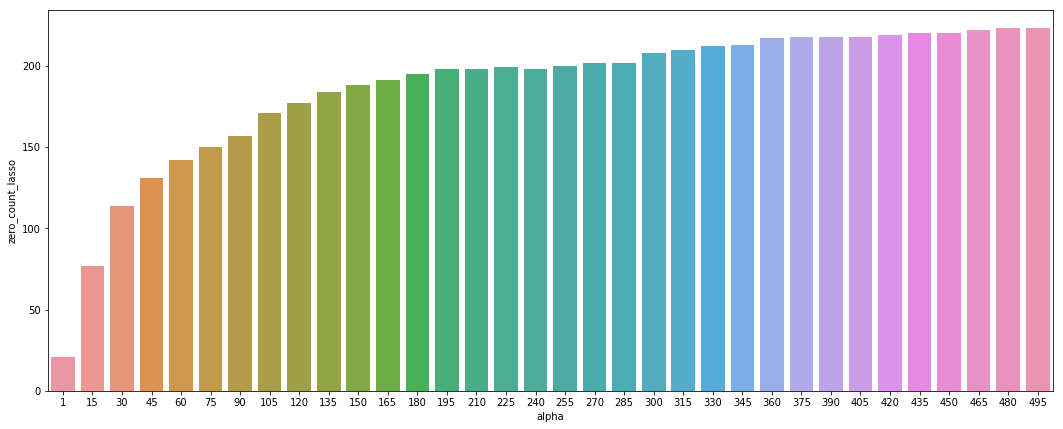

In [31]:
data = pd.DataFrame(data = {'alpha': alphas, 'zero_count_lasso': zero_count_lasso})
plt.subplots(figsize=(18, 7))
sns.barplot(x='alpha', y='zero_count_lasso', data=data)

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

In [32]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(n_jobs=4, alphas=alphas, cv=5)
%time lasso_cv.fit(X, y)

lasso_cv.alpha_

CPU times: user 5.4 s, sys: 2.7 s, total: 8.11 s
Wall time: 2.86 s


150

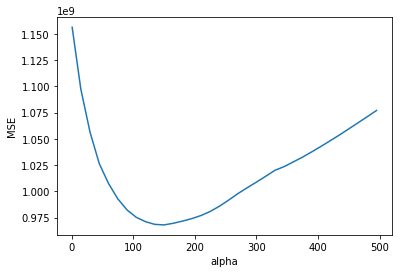

In [33]:
plt.ylabel('MSE')
plt.xlabel('alpha')
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1))

Features with non-zero magnitude: 92


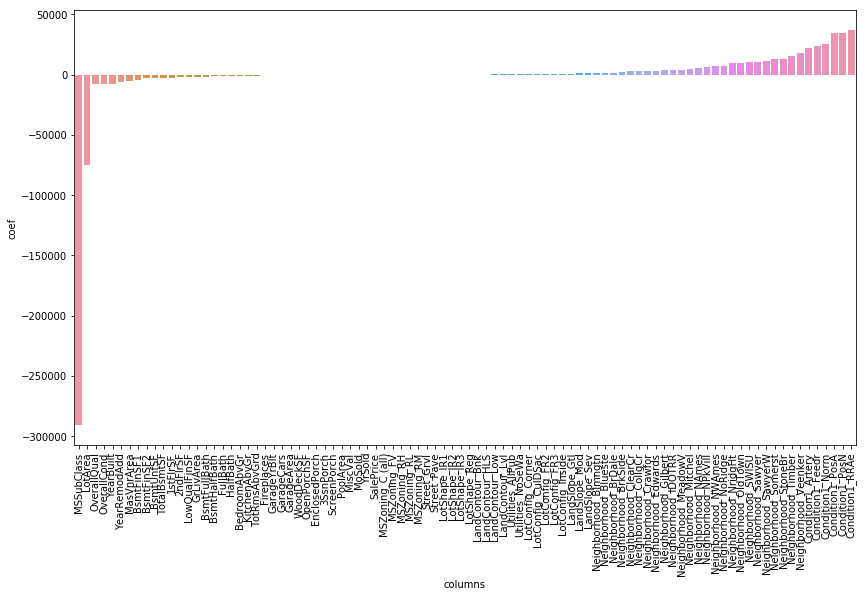

In [34]:
coefs = sorted(lasso_cv.coef_[np.abs(lasso_cv.coef_) > 0.0001])
print('Features with non-zero magnitude:', len(coefs))

plt.figure(figsize=(14,8))

bar = sns.barplot(
    x='columns', y='coef',
    data=pd.DataFrame(list(zip(coefs, df.columns)), columns=["coef", "columns"])
)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90, fontdict={'fontsize': 10})

bar

In [35]:
np.mean(cross_val_score(lasso_cv, X, y, cv=5, n_jobs=4, scoring='neg_mean_squared_error'))

-1003800703.9266504

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
print('X_train:', X_train.shape, ',  X_test:', X_test.shape)

X_train: (978, 280) ,  X_test: (482, 280)


Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [37]:
lasso_cv = LassoCV(n_jobs=4, alphas=alphas, cv=5)
%time lasso_cv.fit(X_train, y_train)

predictions = lasso_cv.predict(X_test)

CPU times: user 5.41 s, sys: 3.4 s, total: 8.81 s
Wall time: 2.82 s


Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

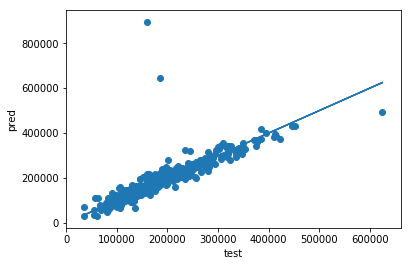

In [38]:
plt.xlabel('test')
plt.ylabel('pred')
plt.plot(y_test, y_test)
plt.scatter(y_test, predictions)

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
X, y = df.drop(labels=['SalePrice'], axis=1), df.SalePrice
lasso = Lasso(alpha=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
%time lasso.fit(X, y)

predictions = lasso.predict(X_test)
mean_squared_error(y_test, predictions)

CPU times: user 2.5 s, sys: 0 ns, total: 2.5 s
Wall time: 2.55 s


375275730.47255123

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.